In [22]:
import os
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Multiply, Reshape, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# ========== CONFIG ==========
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_PHASE_1 = 10
EPOCHS_PHASE_2 = 30
LEARNING_RATE_PHASE_1 = 1e-4
LEARNING_RATE_PHASE_2 = 1e-5
UNFREEZE_LAYERS = 50

In [20]:
BASE_DIR = "/mnt/k/ml/clg_ml/domain_specific_classification"
train_dir = os.path.join(BASE_DIR, "train/oral_disorder")
val_dir = os.path.join(BASE_DIR, "val/oral_disorder")
test_dir = os.path.join(BASE_DIR, "test/oral_disorder")
MODEL_PATH = "oral_disorder_model.h5"
google_images_dir = '/mnt/k/ml/clg_ml/imgs_from_google/domainSpecificClassifier/oral_disorders/'
class_labels = ['hypodontia', 'mouth_ulcers']

In [5]:
# ========== SE BLOCK ==========
def squeeze_excite_block(input_tensor, ratio=16):
    '''Create a squeeze and excitation block'''
    filters = input_tensor.shape[-1]
    se = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = Multiply()([input_tensor, se])
    return x

In [6]:
# ========== DATA ==========
def create_generators():
    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    ).flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)

    val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
    test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
    return train_gen, val_gen, test_gen

In [7]:
# ========== MODEL ==========
def build_model(num_classes):
    base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False  # Phase 1: freeze backbone

    x = base.output
    x = squeeze_excite_block(x)  # <-- Attention block here

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=base.input, outputs=output), base

In [11]:
# ========== TRAINING ==========
def train_model():
    train_gen, val_gen, test_gen = create_generators()
    model, base_model = build_model(num_classes=2)

    # Phase 1: Train top classifier
    print("🔹 Phase 1: Training classifier head...")
    model.compile(optimizer=Adam(LEARNING_RATE_PHASE_1), loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(patience=3, factor=0.2, min_lr=1e-6),
        ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_accuracy', verbose=1)
    ]

    model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS_PHASE_1, callbacks=callbacks)

    # Phase 2: Fine-tuning last N layers
    print("🔹 Phase 2: Fine-tuning base model...")
    base_model.trainable = True
    for layer in base_model.layers[:-UNFREEZE_LAYERS]:
        layer.trainable = False

    model.compile(optimizer=Adam(LEARNING_RATE_PHASE_2), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS_PHASE_2, callbacks=callbacks)

    # Load best weights before evaluation
    print("📦 Loading best model weights...")
    model.load_weights(MODEL_PATH)

    # Final evaluation
    evaluate_model(model, test_gen)

In [12]:
def evaluate_model(model, test_gen):
    print("📊 Evaluating model on test set...")
    test_gen.reset()
    
    y_true = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())
    
    # Predict probabilities
    y_pred_probs = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    print(f"\n✅ Test Accuracy: {accuracy:.4f}\n")

    # Classification Report
    print("📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion Matrix
    print("🔁 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [14]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

In [17]:
def classify_images():
    model = tf.keras.models.load_model(MODEL_PATH)
    print(f"🔍 Loaded model from: {MODEL_PATH}")

    image_files = [f for f in os.listdir(google_images_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp'))]

    if not image_files:
        print("❌ No images found in directory.")
        return

    print(f"\n🧪 Classifying {len(image_files)} images from: {google_images_dir}\n")

    for img_file in sorted(image_files):
        img_path = os.path.join(google_images_dir, img_file)
        img_array = preprocess_image(img_path)

        preds = model.predict(img_array, verbose=0)
        pred_index = np.argmax(preds[0])
        confidence = preds[0][pred_index] * 100

        predicted_class = class_labels[pred_index]
        print(f"{img_file} → Predicted: {predicted_class} ({confidence:.2f}%)")

Found 4379 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 540 images belonging to 2 classes.


I0000 00:00:1759999396.909380   27723 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


🔹 Phase 1: Training classifier head...


/mnt/k/ml/clg_ml/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-10-09 14:13:28.918941: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f023c089970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-09 14:13:28.918975: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-10-09 14:13:29.250323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-09 14:13:30.805374: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-10-09 14:13:31.231113: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-09 14:13

 43/137 ━━━━━━━━━━━━━━━━━━━━ 37s 402ms/step - accuracy: 0.5817 - loss: 0.7063

2025-10-09 14:14:14.600354: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-09 14:14:14.600433: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-09 14:14:14.944652: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11943', 16 bytes spill stores, 16 bytes spill loads



137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.7123 - loss: 0.5377

2025-10-09 14:15:14.446278: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-09 14:15:14.861272: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3399', 8 bytes spill stores, 8 bytes spill loads

2025-10-09 14:15:15.318796: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3406', 20 bytes spill stores, 20 bytes spill loads

2025-10-09 14:15:26.338467: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set 


Epoch 1: val_accuracy improved from None to 0.93333, saving model to oral_disorder_model.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 145s 823ms/step - accuracy: 0.8246 - loss: 0.3799 - val_accuracy: 0.9333 - val_loss: 0.2344 - learning_rate: 1.0000e-04
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9398 - loss: 0.1681
Epoch 2: val_accuracy improved from 0.93333 to 0.97407, saving model to oral_disorder_model.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 40s 292ms/step - accuracy: 0.9434 - loss: 0.1576 - val_accuracy: 0.9741 - val_loss: 0.1072 - learning_rate: 1.0000e-04
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9548 - loss: 0.1178
Epoch 3: val_accuracy improved from 0.97407 to 0.99444, saving model to oral_disorder_model.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 42s 307ms/step - accuracy: 0.9559 - loss: 0.1140 - val_accuracy: 0.9944 - val_loss: 0.0376 - learning_rate: 1.0000e-04
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9682 - loss: 0.0905
Epoch 4: val_accuracy improved from 0.99444 to 0.99630, saving model to oral_disorder_model.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 39s 286ms/step - accuracy: 0.9692 - loss: 0.0903 - val_accuracy: 0.9963 - val_loss: 0.0243 - learning_rate: 1.0000e-04
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9767 - loss: 0.0725
Epoch 5: val_accuracy improved from 0.99630 to 0.99815, saving model to oral_disorder_model.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - accuracy: 0.9740 - loss: 0.0760 - val_accuracy: 0.9981 - val_loss: 0.0171 - learning_rate: 1.0000e-04
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9747 - loss: 0.0673
Epoch 6: val_accuracy did not improve from 0.99815
137/137 ━━━━━━━━━━━━━━━━━━━━ 38s 279ms/step - accuracy: 0.9788 - loss: 0.0599 - val_accuracy: 0.9981 - val_loss: 0.0137 - learning_rate: 1.0000e-04
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9834 - loss: 0.0422
Epoch 7: val_accuracy did not improve from 0.99815
137/137 ━━━━━━━━━━━━━━━━━━━━ 38s 274ms/step - accuracy: 0.9810 - loss: 0.0450 - val_accuracy: 0.9981 - val_loss: 0.0077 - learning_rate: 1.0000e-04
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9847 - loss: 0.0467
Epoch 8: val_accuracy improved from 0.99815 to 1.00000, saving model to oral_disorder_model.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 40s 288ms/step - accuracy: 0.9849 - loss: 0.0447 - val_accuracy: 1.0000 - val_loss: 0.0063 - learning_rate: 1.0000e-04
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9911 - loss: 0.0347
Epoch 9: val_accuracy did not improve from 1.00000
137/137 ━━━━━━━━━━━━━━━━━━━━ 37s 273ms/step - accuracy: 0.9872 - loss: 0.0400 - val_accuracy: 1.0000 - val_loss: 0.0049 - learning_rate: 1.0000e-04
Epoch 10/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9895 - loss: 0.0347
Epoch 10: val_accuracy did not improve from 1.00000
137/137 ━━━━━━━━━━━━━━━━━━━━ 38s 277ms/step - accuracy: 0.9868 - loss: 0.0357 - val_accuracy: 1.0000 - val_loss: 0.0095 - learning_rate: 1.0000e-04
🔹 Phase 2: Fine-tuning base model...
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9809 - loss: 0.0512
Epoch 1: val_accuracy did not improve from 1.00000
137/137 ━━━━━━━━━━━━━━━━━━━━ 95s 488ms/step - accuracy: 0.9824 - loss: 0.0471 - val_accuracy: 1.0000

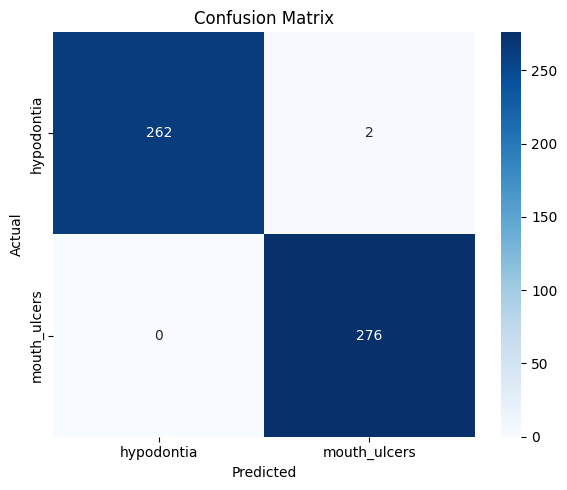

In [13]:
if __name__ == "__main__":
    train_model()

In [23]:
classify_images()

🔍 Loaded model from: oral_disorder_model.h5

🧪 Classifying 6 images from: /mnt/k/ml/clg_ml/imgs_from_google/domainSpecificClassifier/oral_disorders/

hypo.jpeg → Predicted: hypodontia (100.00%)
hypo2.jpg → Predicted: hypodontia (76.48%)
hypo3.jpg → Predicted: hypodontia (99.04%)
mo_ul.jpeg → Predicted: mouth_ulcers (82.92%)
mo_ul2.jpg → Predicted: mouth_ulcers (94.06%)
mo_ul3.jpg → Predicted: mouth_ulcers (99.78%)
